In [ ]:
from google.colab import files
upload=files.upload()

Saving employee_retention_data.csv to employee_retention_data.csv


In [ ]:
! pip install h2o

     |████████████████████████████████| 128.3MB 80kB/s 
  Created wheel for h2o: filename=h2o-3.30.0.4-py2.py3-none-any.whl size=128397038 sha256=48ed07e125ae8abfca3019b63662a1fbeef98a58fec7c02b9f00a1638bb997b8
  Stored in directory: /root/.cache/pip/wheels/ad/bd/cc/0a8c7dffc4772df0bbfae4c1c7a9d64525fcd3ada9694dd8c3
Successfully built h2o


# Question:
We got employee data from a few companies. We have data about all employees who joined from 2011/01/24 to 2015/12/13. For each employee, we also know if they are still at the company as of 2015/12/13 or they have quit. Beside that, we have general info about the employee, such as avg salary during her tenure, dept, and yrs of experience.

As said above, the goal is to predict employee retention and understand its main drivers. Specifically, you should:

Assume, for each company, that the headcount starts from zero on 2011/01/23. Estimate employee headcount, for each company, on each day, from 2011/01/24 to 2015/12/13. That is, if by 2012/03/02 2000 people have joined company 1 and 1000 of them have already quit, then company headcount on 2012/03/02 for company 1 would be 1000. You should create a table with 3 columns: day, employee_headcount, company_id.

What are the main factors that drive employee churn? Do they make sense? Explain your findings.

If you could add to this data set just one variable that could help explain employee churn, what would that be?

# Answer:

at the bottom of this file

Create table 

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

import sklearn
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import auc, roc_curve, classification_report

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

%matplotlib inline

In [ ]:
emp_retention=pd.read_csv('employee_retention_data.csv')
emp_retention.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [ ]:
emp_retention.describe()

,employee_id,company_id,seniority,salary
count,24702.000000,24702.000000,24702.000000,24702.000000
mean,501604.403530,3.426969,14.127803,138183.345478
std,288909.026101,2.700011,8.089520,76058.184573
min,36.000000,1.000000,1.000000,17000.000000
25%,250133.750000,1.000000,7.000000,79000.000000
50%,500793.000000,2.000000,14.000000,123000.000000
75%,753137.250000,5.000000,21.000000,187000.000000
max,999969.000000,12.000000,99.000000,408000.000000


In [ ]:
emp_retention.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   employee_id  24702 non-null  float64
 1   company_id   24702 non-null  int64  
 2   dept         24702 non-null  object 
 3   seniority    24702 non-null  int64  
 4   salary       24702 non-null  float64
 5   join_date    24702 non-null  object 
 6   quit_date    13510 non-null  object 
dtypes: float64(2), int64(2), object(3)
memory usage: 1.3+ MB


In [ ]:
#There are nulls in quit_date column, that means those employees haven't quited from company
date_interval=pd.date_range(start='2011-01-24',end='2015-12-13',freq='D')
date_interval1=pd.to_datetime(date_interval,format='%Y%m%d')
company_list=emp_retention['company_id'].unique()
emp_r2=emp_retention[['employee_id','company_id','join_date','quit_date']]

In [ ]:
date_list=[]
cid_list=[]
headcount_list=[]
for date in date_interval1:
  for cid in company_list:
    date1=str(date)[:10]
    employee_headcount=len(emp_r2.loc[(emp_r2['company_id']==cid) & (emp_r2['join_date']<=date1) & ((emp_r2['quit_date']>=date1)|(emp_r2['quit_date'].isnull()))])
    date_list.append(date1)
    cid_list.append(cid)
    headcount_list.append(employee_headcount)
    #cmp_headcount = cmp_headcount.append({'day' : date1 , 'employee_headcount' : employee_headcount, 'company_id':cid} , ignore_index=True)


In [ ]:
cmp_headcount = pd.DataFrame(list(zip(date_list, headcount_list,cid_list)), 
               columns =['day' , 'employee_headcount', 'company_id']) 
cmp_headcount.sort_values(by=['day','company_id']).head()

,day,employee_headcount,company_id
4,2011-01-24,25,1
2,2011-01-24,17,2
8,2011-01-24,9,3
1,2011-01-24,12,4
7,2011-01-24,5,5


Analyze employment churn

In [ ]:
#add two variables 'still_work' and 'working_day' to easily show information from join date and quit date
emp_retention['still_work']= np.where(emp_retention['quit_date'].isnull(), 1, 0)
emp_retention['quit_date2']=np.where(emp_retention['quit_date'].isnull(),'2015-12-13',emp_retention['quit_date'])
emp_retention['working_day']= np.where(emp_retention['quit_date'].isnull(),pd.to_datetime(emp_retention['quit_date2'])-pd.to_datetime(emp_retention['join_date']),pd.to_datetime(emp_retention['quit_date'])-pd.to_datetime(emp_retention['join_date']))
emp_retention['working_day']=emp_retention['working_day'].dt.days.astype(int)
emp_retention

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,still_work,quit_date2,working_day
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,0,2015-10-30,585
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,0,2014-04-04,340
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN,1,2015-12-13,426
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,0,2013-06-07,389
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,0,2014-08-22,1040
...,...,...,...,...,...,...,...,...,...,...
24697,549847.0,3,customer_service,16,97000.0,2015-02-18,NaN,1,2015-12-13,298
24698,590087.0,4,engineer,10,160000.0,2015-10-26,NaN,1,2015-12-13,48
24699,777612.0,4,customer_service,11,67000.0,2013-09-03,2015-10-23,0,2015-10-23,780
24700,97289.0,10,engineer,98,266000.0,2011-12-13,2015-01-09,0,2015-01-09,1123


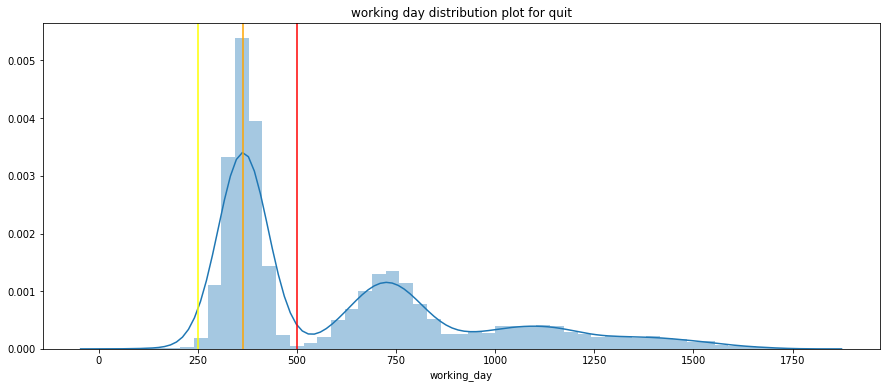

In [ ]:
#draw plot to see after how many working days people will choose to quit
fig,ax=plt.subplots(figsize=(15,6))
sns.distplot(emp_retention[emp_retention['still_work']==0]['working_day'],label='quit')
ax.set_title('working day distribution plot for quit')
ax.axvline(x=500,color='red')
ax.axvline(x=365,color='orange')
ax.axvline(x=250,color='yellow')
plt.show()

A large group of people will choose to quit around their first anniversary (365 day, orange line). The first leaving peak period is from around 250 days to 500 days. So in following analysis, I would like to define the employee churn happens after 500 days from they joined the company.

In [ ]:
length=pd.to_datetime(emp_retention['quit_date'])-pd.to_datetime(emp_retention['join_date'])
length1=length.apply(lambda x:float(x.days))
emp_retention['churn']= np.where(length1<500, 1, 0)
emp_retention.head()


,employee_id,company_id,dept,seniority,salary,join_date,quit_date,still_work,quit_date2,working_day,churn
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,0,2015-10-30,585,0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,0,2014-04-04,340,1
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN,1,2015-12-13,426,0
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,0,2013-06-07,389,1
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,0,2014-08-22,1040,0


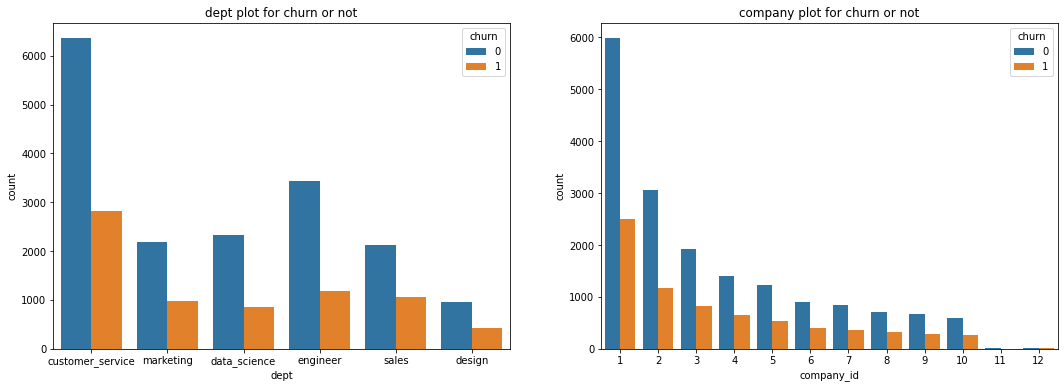

In [ ]:
# do some visualization for separate factors
#dept/company
fig,ax=plt.subplots(figsize=(18,6),nrows=1,ncols=2)
sns.countplot(x=emp_retention['dept'],hue=emp_retention['churn'],ax=ax[0])
ax[0].set_title('dept plot for churn or not')
sns.countplot(x=emp_retention['company_id'],hue=emp_retention['churn'],ax=ax[1])
ax[1].set_title('company plot for churn or not')
plt.show()

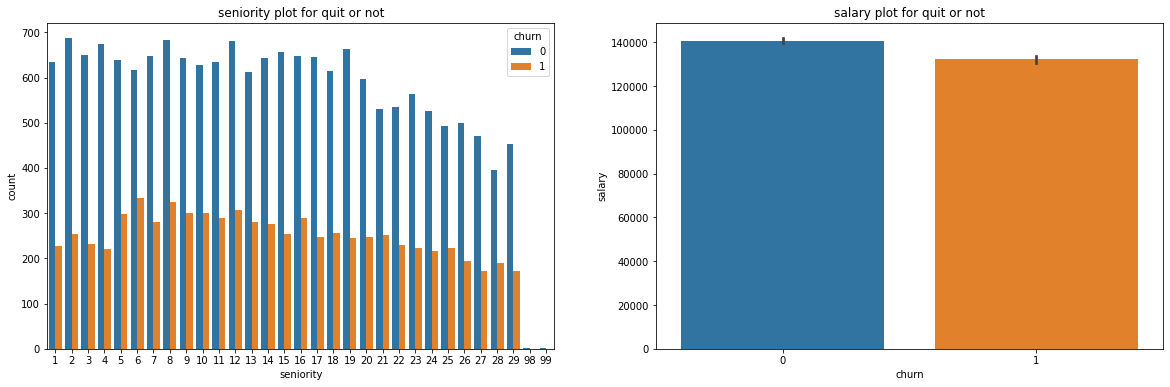

In [ ]:
#seniority / salary
fig,ax=plt.subplots(figsize=(20,6),nrows=1,ncols=2)
sns.countplot(x=emp_retention['seniority'],hue=emp_retention['churn'],ax=ax[0])
ax[0].set_title('seniority plot for churn or not')
sns.barplot(x=emp_retention['churn'],y=emp_retention['salary'],ax=ax[1])
ax[1].set_title('salary plot for churn or not')
plt.show()

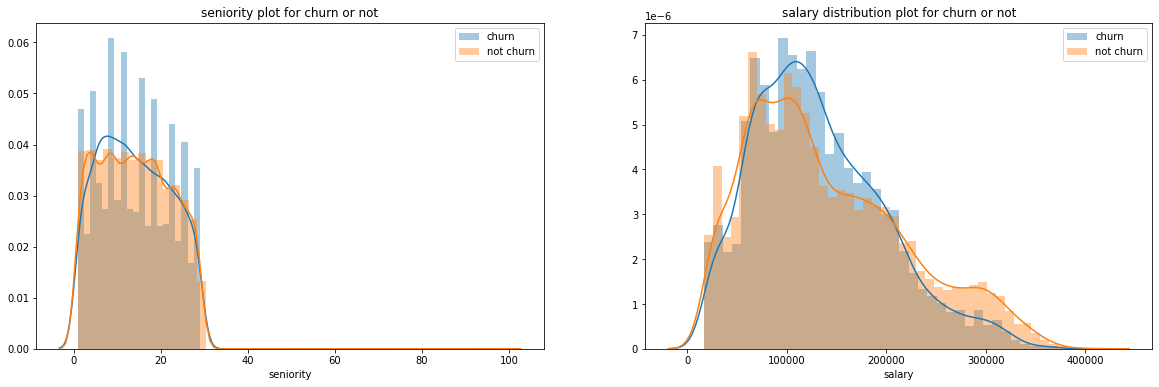

In [ ]:
fig,ax=plt.subplots(figsize=(20,6),nrows=1,ncols=2)
sns.distplot(emp_retention[emp_retention['churn']==1]['seniority'],label='churn',ax=ax[0])
sns.distplot(emp_retention[emp_retention['churn']==0]['seniority'],label='not churn',ax=ax[0])
ax[0].set_title('seniority plot for churn or not')
ax[0].legend()
sns.distplot(emp_retention[emp_retention['churn']==1]['salary'],label='churn',ax=ax[1])
sns.distplot(emp_retention[emp_retention['churn']==0]['salary'],label='not churn',ax=ax[1])
ax[1].set_title('salary distribution plot for churn or not')
ax[1].legend()
plt.show()

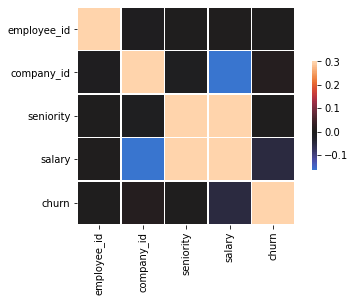

In [ ]:
emp_retention_heat=emp_retention.drop(columns={'still_work','working_day'})
sns.heatmap(emp_retention_heat.corr(), vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

From these plots, we can find that salary maybe a big factor of employee churn. We can build some models like decision tree to get more information and support.

In [ ]:
#get quit year
#analysis if have special date that a lot of people choose to early quit

emp_retention['quit_date_year'] = pd.to_datetime(emp_retention["quit_date"]).dt.strftime('%Y')
emp_retention_group_qd=emp_retention.loc[emp_retention['churn']==1].groupby(emp_retention['quit_date_year']).agg({'employee_id':'count'}).reset_index()
emp_retention_group_qd=emp_retention_group_qd.rename(columns={'employee_id':'early_quit_count'})
emp_retention_group_qd.head()

,quit_date_year,early_quit_count
0,2011,37
1,2012,1727
2,2013,1909
3,2014,1860
4,2015,1807


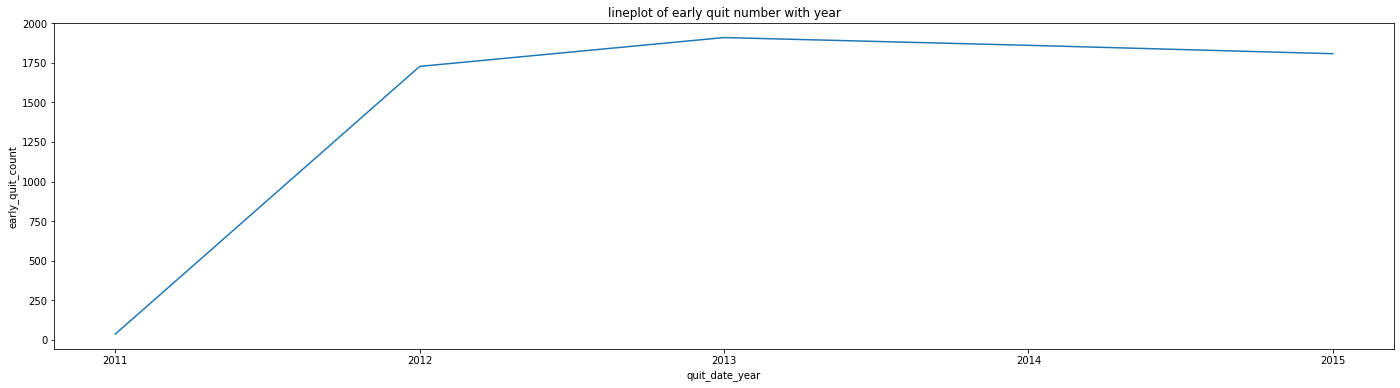

In [ ]:
fig,ax=plt.subplots(figsize=(24,6))
sns.lineplot(x=emp_retention_group_qd['quit_date_year'],y=emp_retention_group_qd['early_quit_count'])
ax.set_title('lineplot of early quit number with year')
plt.show()

From this plot, we can find that the industral environment's change may lead to more employee churn, but we need more information to support and analyze this factor.

Machine learning 

In [ ]:
# use h2o cluster to handle importance disappear problem with dummy in sklearn tree
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.7" 2020-04-14; OpenJDK Runtime Environment (build 11.0.7+10-post-Ubuntu-2ubuntu218.04); OpenJDK 64-Bit Server VM (build 11.0.7+10-post-Ubuntu-2ubuntu218.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmplmeg768s
  JVM stdout: /tmp/tmplmeg768s/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmplmeg768s/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.4
H2O_cluster_version_age:,9 days
H2O_cluster_name:,H2O_from_python_unknownUser_upvaxk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.180 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


In [ ]:
h2o_emp_retention=H2OFrame(emp_retention)

h2o_emp_retention['churn'] = h2o_emp_retention['churn'].asfactor()
#h2o_emp_retention['converted'] = h2o_conv['converted'].asfactor()

h2o_emp_retention.summary()

Parse progress: |█████████████████████████████████████████████████████████| 100%


,employee_id,company_id,dept,seniority,salary,join_date,quit_date,still_work,quit_date2,working_day,churn,quit_date_year
type,int,int,enum,int,int,time,time,int,time,int,enum,int
mins,36.0,1.0,,1.0,17000.0,1295827200000.0,1318464000000.0,0.0,1318464000000.0,3.0,,2011.0
mean,501604.4035300784,3.426969476155781,,14.127803416727366,138183.34547809843,1372498777556.4734,1399052618327.16,0.453080722208728,1422119946368.7202,574.3190834750261,,2013.8324204293133
maxs,999969.0,12.0,,99.0,408000.0,1449705600000.0,1449619200000.0,1.0,1449964800000.0,1777.0,,2015.0
sigma,288909.0261007113,2.7000109677072097,,8.089519596306804,76058.18457287704,44439198685.29434,33384290754.076416,0.49780378995807595,35381625356.23376,361.59237937667956,,1.0511600440225346
zeros,0,0,,0,0,0,0,13510,0,0,,0
missing,0,0,0,0,0,0,11192,0,0,0,0,11192
0,13021.0,7.0,customer_service,28.0,89000.0,2014-03-24 00:00:00,2015-10-30 00:00:00,0.0,2015-10-30 00:00:00,585.0,0,2015.0
1,825355.0,7.0,marketing,20.0,183000.0,2013-04-29 00:00:00,2014-04-04 00:00:00,0.0,2014-04-04 00:00:00,340.0,1,2014.0
2,927315.0,4.0,marketing,14.0,101000.0,2014-10-13 00:00:00,,1.0,2015-12-13 00:00:00,426.0,0,nan


In [ ]:
strat_split=h2o_emp_retention['churn'].stratified_split(test_frac=0.25)
trainh2o=h2o_emp_retention[strat_split=='train']
testh2o=h2o_emp_retention[strat_split=='test']
feature=['company_id','dept','seniority','salary']
target='churn'

drf Model Build progress: |███████████████████████████████████████████████| 100%


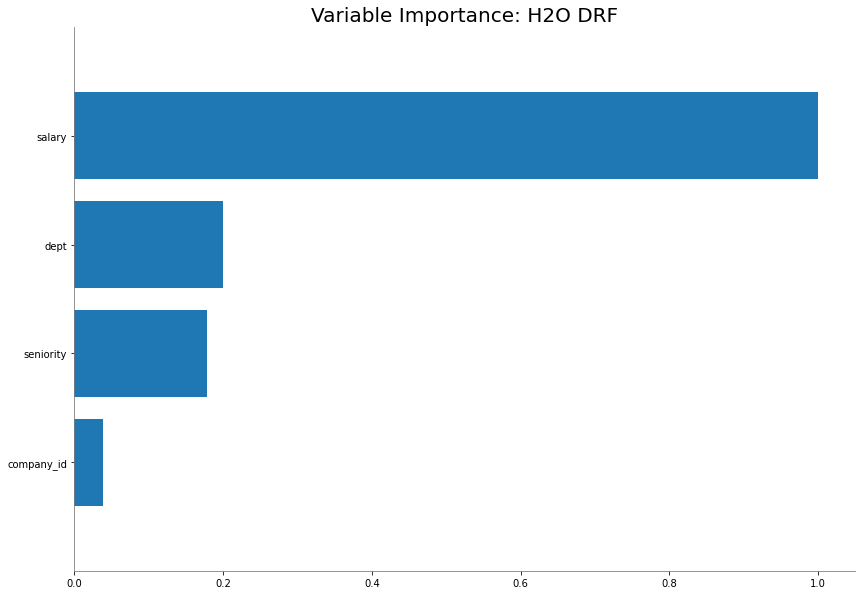

In [ ]:
modelh2o=H2ORandomForestEstimator(max_depth=3)
modelh2o.train(x=feature,y=target,training_frame=trainh2o)
modelh2o.varimp_plot()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/h2o/model/model_base.py:1359: MatplotlibDeprecationWarning: The parameter where must have the same size as x in fill_between(). This will become an error in future versions of Matplotlib.
  axs.fill_between(x, lower, upper, where=lower < upper, alpha=0.1, interpolate=False)


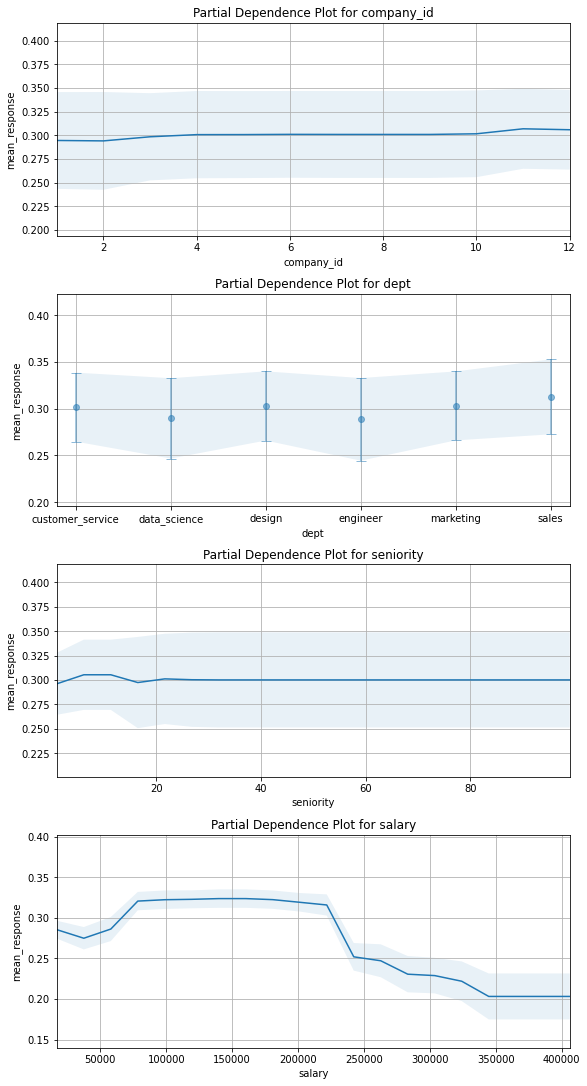

In [ ]:
#partial plot show analysis for individual variables
_=modelh2o.partial_plot(trainh2o,cols=feature,figsize=(8,15))

From these partial plot we can see that salary is the most important factor. Employee with salary within 50000 to 24000 are more likely to leave early. Probably because employees with high salaries are happy there and employees with low salaries are not that marketable, so they have a hard time finding a new job.

For new variable to consider, because salary is the most effective factor, I would recommend to add variables like promotion or raise received during employee tenure. 